In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import meshio
from pathlib import Path


import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap, random
import optax
from tqdm.auto import tqdm
from typing import Callable
import pickle
import equinox as eqx

import os

from triangular_transport.flows.flow_trainer import NNTrainer
from triangular_transport.flows.sde_flow_trainer import NNSDE

from triangular_transport.flows.loss_functions import vec_field_loss, denoiser_loss
# from triangular_transport.networks.flow_networks import MLP, MLP_Triangular
from triangular_transport.flows.methods.utils import UnitGaussianNormalizer
from triangular_transport.flows.dataloaders import gaussian_reference_sampler
from triangular_transport.kernels.kernel_tools import get_gaussianRBF, vectorize_kfunc

import json
import h5py

import argparse

plt.style.use("ggplot")

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
jax.config.update("jax_default_device", jax.devices()[1])

In [2]:
def read_data_h5(path="data.h5"):
    with h5py.File(path, "r") as f:
        targets = f["/target"][...]
        data = f["/data"][...]
    return targets, data

In [3]:
with open("poisson.yaml") as fid:
    inargs = yaml.full_load(fid)

utrue = np.load("training_dataset/true_param_grid.npy")
ytrue = np.load("training_dataset/true_state_grid.npy")
map_est = np.load("training_dataset/map_param_grid.npy")
targets, yobs = read_data_h5()

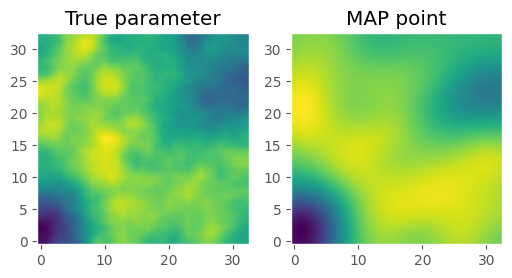

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

ax[0].imshow(utrue, origin="lower", interpolation="bilinear")
ax[0].set_title("True parameter")
ax[0].grid(False)

ax[1].imshow(map_est, origin="lower", interpolation="bilinear")
ax[1].set_title("MAP point")
ax[1].grid(False)

In [5]:
nsamples = inargs["MCMC"]["nsamples"] - inargs["MCMC"]["burnin"]

hmala_samps = np.load("training_dataset/chain_30/hmala_samples_grid_delta.npy").reshape(
    nsamples, 33, 33
)
hmala_mean = np.mean(hmala_samps, axis=0)
hmala_var = np.var(hmala_samps, axis=0)

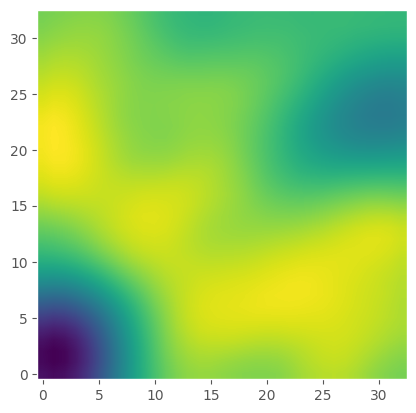

In [6]:
plt.imshow(hmala_mean, origin="lower", interpolation="bilinear")
plt.grid(False)

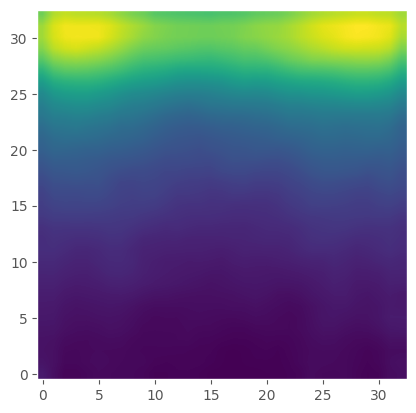

In [7]:
plt.imshow(hmala_var, origin="lower", interpolation="bilinear")
plt.grid(False)

In [8]:
from typing import Callable, List

class MLP(eqx.Module):
    layers: List[eqx.nn.Linear]         # main hidden layers
    skips:  List[eqx.nn.Linear | None]  # projections for residuals (or None for identity)
    out:    eqx.nn.Linear
    activation_fn: List[Callable]

    def __init__(
        self,
        key: jax.random.PRNGKey,
        dim: int,
        out_dim: int | None = None,
        num_layers: int = 4,
        activation_fn: List[Callable] | Callable = jax.nn.gelu,
        w: int | List[int] = 64,
        time_varying: bool = False,
    ):
        if out_dim is None:
            out_dim = dim

        # normalize activation list
        if isinstance(activation_fn, list):
            if len(activation_fn) == 1:
                activation_fn *= num_layers - 1
        else:
            activation_fn = [activation_fn] * (num_layers - 1)
        self.activation_fn = activation_fn

        # normalize widths
        if isinstance(w, list):
            if len(w) == 1:
                w *= (num_layers - 1)
            widths = w
        else:
            widths = [w] * (num_layers - 1)

        k = jax.random.split(key, 2 * num_layers)  # enough keys

        in_dim0 = dim + (1 if time_varying else 0)

        # build hidden layers + skip projections
        self.layers = []
        self.skips  = []
        in_dim = in_dim0
        for i, width in enumerate(widths):
            self.layers.append(eqx.nn.Linear(in_dim, width, key=k[i]))
            # projection: identity if dims match, else linear map
            if in_dim == width:
                self.skips.append(None)  # treat as identity in __call__
            else:
                self.skips.append(eqx.nn.Linear(in_dim, width, key=k[i + num_layers]))
            in_dim = width

        # output layer
        self.out = eqx.nn.Linear(in_dim, out_dim, key=k[-1])

    def __call__(self, x):
        for layer, skip, act in zip(self.layers, self.skips, self.activation_fn):
            h = act(layer(x))
            s = x if skip is None else skip(x)
            x = h + s                    # projected residual
        return self.out(x)

In [9]:
train_dim = 50000
nx = ny = 33
flat_length = nx * ny
ys = (np.load("training_dataset/solutions_grid_delta.npy"))[:train_dim]
us = (np.load("training_dataset/parameters_delta.npy"))[:train_dim, :].reshape(
    train_dim, flat_length
)

us_ref = us.copy()
np.random.shuffle(us_ref)

us_test = (np.load("training_dataset/parameters_delta.npy"))[
    train_dim : train_dim + 20000, :
].reshape(20000, flat_length)
np.random.shuffle(us_test)

ys_normalizer = UnitGaussianNormalizer(ys)
ys_normalized = ys_normalizer.encode()

2025-10-29 21:43:10.769774: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
mean_us = us_ref.mean(axis=0)
X = us - mean_us

U, S, Vt = np.linalg.svd(us / (np.sqrt(train_dim - 1)), full_matrices=False)
V = Vt.T

expl_var = (S**2) / (S**2).sum()
k = np.searchsorted(np.cumsum(expl_var), 0.98) + 1
# k = 30

V = V[:, :k]
S = S[:k]

alpha = 0.1


def pca_encode(b):
    # whitened coeffs z
    return (b - mean_us) @ V / S


def pca_decode(z):
    # undo whitening
    return mean_us + (z * S) @ V.T

In [11]:
us_pca = pca_encode(us)
us_ref_pca = pca_encode(us_ref)
us_test_pca = pca_encode(us_test)

target_data = jnp.hstack([ys_normalized, us_pca])
ref_data = jnp.hstack([ys_normalized, us_ref_pca])

In [12]:
def gamma(t):
    return 0.1 * jnp.sqrt(2 * (t - t**2) + 1e-8)


gamma_vmap = vmap(gamma)

gammadot = vmap(grad(gamma))


@vmap
def linear_interpolant(t, x1, x0, z):
    return t * x1 + (1 - t) * x0 + gamma_vmap(t) * z


@vmap
def linear_interpolant_der(t, x1, x0, z):
    return x1 - x0 + gammadot(t) * z

In [13]:
key = random.PRNGKey(seed=42)
key1, key2 = random.split(key=key, num=2)
batch_size = 128
steps = 50000
print_every = 5000
yu_dimension = (100, k.item())
dim = yu_dimension[0] + yu_dimension[1]
hidden_layer_list = [512] * 4
velocity = MLP(
    key=key2,
    dim=dim,
    time_varying=True,
    w=hidden_layer_list,
    num_layers=len(hidden_layer_list) + 1,
    activation_fn=jax.nn.gelu,  # GeLU worked well
)

score = MLP(
    key=key2,
    dim=dim,
    time_varying=True,
    w=hidden_layer_list,
    num_layers=len(hidden_layer_list) + 1,
    activation_fn=jax.nn.gelu,  # GeLU worked well
)

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=3e-4,
    warmup_steps=2_000,
    decay_steps=steps,
    end_value=1e-5,
)
# v_optimizer = optax.adamw(schedule)
# s_optimizer = optax.adamw(schedule)
v_optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(schedule))
s_optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(schedule))
interpolant = linear_interpolant
interpolant_der = linear_interpolant_der
interpolant_args = {"t": None, "x1": None, "x0": None, "z": None}

In [14]:
trainer = NNSDE(
    target_density=None,
    velocity=velocity,
    score=score,
    v_optimizer=v_optimizer,
    s_optimizer=s_optimizer,
    interpolant=interpolant,
    interpolant_der=interpolant_der,
    reference_sampler=gaussian_reference_sampler,
    v_loss=vec_field_loss,
    s_loss=denoiser_loss,
    interpolant_args=interpolant_args,
    yu_dimension=yu_dimension,
)
trainer.train(
    x1_data=target_data,
    train_dim=train_dim,
    batch_size=batch_size,
    steps=steps,
    x0_data=ref_data,
);

Training neural network


  0%|          | 0/50000 [00:00<?, ?it/s]

step = 0, train_v_loss = 29.833206176757812, train_eta_loss = 5.068475723266602, train_loss = 34.901681900024414
step = 5000, train_v_loss = -49.460479736328125, train_eta_loss = -9.474050521850586, train_loss = -58.93453025817871
step = 10000, train_v_loss = -48.607460021972656, train_eta_loss = -12.213432312011719, train_loss = -60.820892333984375
step = 15000, train_v_loss = -52.795143127441406, train_eta_loss = -3.6517333984375, train_loss = -56.446876525878906
step = 20000, train_v_loss = -51.059234619140625, train_eta_loss = -11.625381469726562, train_loss = -62.68461608886719
step = 25000, train_v_loss = -47.37959289550781, train_eta_loss = -19.81855010986328, train_loss = -67.1981430053711
step = 30000, train_v_loss = -48.86857986450195, train_eta_loss = -17.010562896728516, train_loss = -65.87914276123047
step = 35000, train_v_loss = -50.97759246826172, train_eta_loss = -7.534505844116211, train_loss = -58.51209831237793
step = 40000, train_v_loss = -48.696685791015625, train_

In [15]:
no_samples = inargs["MCMC"]["nsamples"] - inargs["MCMC"]["burnin"]
ytrue_flat = yobs.copy()
ytrue_flat_normalized = ys_normalizer.encode(ytrue_flat)
ys_test_normalized = jnp.full(
    (no_samples, ytrue_flat_normalized.shape[0]), ytrue_flat_normalized
)
x0_test = jnp.hstack([ys_test_normalized, us_test_pca])
# x0_test = jnp.hstack([ys_test_normalized, us_test])

solver_args = {"saveat": "t1"}
cond_values = ytrue_flat_normalized
cond_samples = trainer.conditional_sample(
    cond_values=cond_values,
    u0_cond=us_test_pca,
    nsamples=20000,
    solver_args=solver_args,
    gamma=gamma,
)
all_samples = cond_samples

u_samples = all_samples[:, yu_dimension[0] :]
u_samples = pca_decode(u_samples)
u_samples = u_samples.reshape(no_samples, nx, ny)
u_means = jnp.mean(u_samples, axis=0)
u_var = jnp.var(u_samples, axis=0)

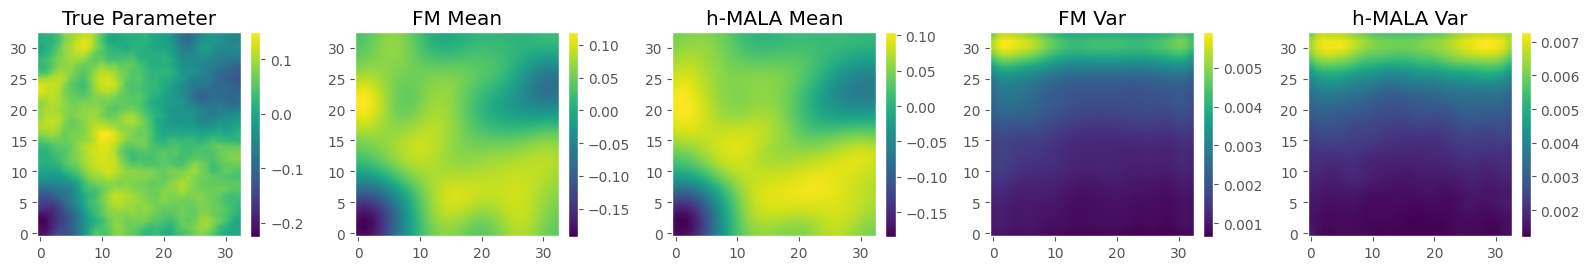

In [16]:
layer_idx = 0
fig, ax = plt.subplots(1, 5, figsize=(16, 4))

im0 = ax[0].imshow(utrue, origin="lower", interpolation="bilinear")
ax[0].set_title("True Parameter")
ax[0].grid(False)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(u_means, origin="lower", interpolation="bilinear")
ax[1].set_title("FM Mean")
ax[1].grid(False)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(hmala_mean, origin="lower", interpolation="bilinear")
ax[2].set_title("h-MALA Mean")
ax[2].grid(False)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

im3 = ax[3].imshow(u_var, origin="lower", interpolation="bilinear")
ax[3].set_title("FM Var")
ax[3].grid(False)
fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

im4 = ax[4].imshow(hmala_var, origin="lower", interpolation="bilinear")
ax[4].set_title("h-MALA Var")
ax[4].grid(False)
fig.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

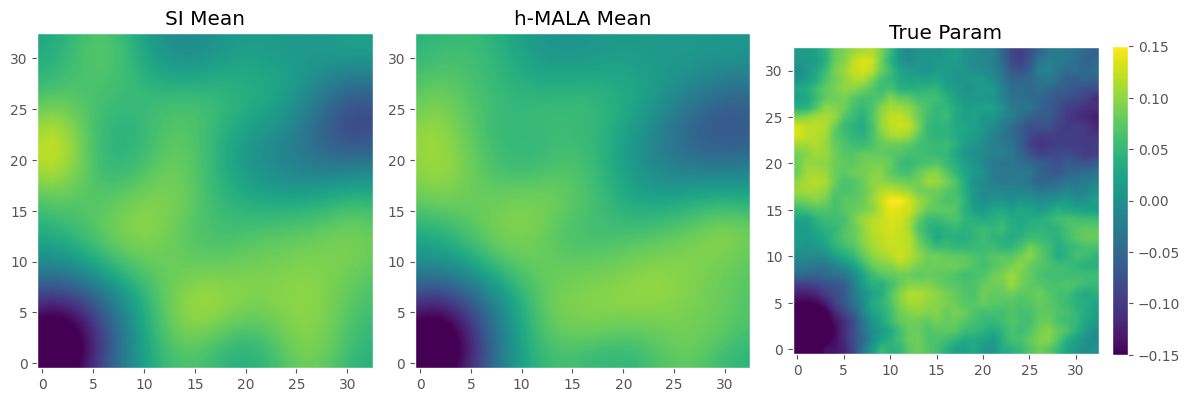

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
vmin, vmax = -0.15, 0.15

im1 = ax[0].imshow(
    u_means,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    interpolation="bilinear",
    origin="lower",
)
ax[0].grid(False)
ax[0].set_title("SI Mean")
im2 = ax[1].imshow(
    hmala_mean,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    interpolation="bilinear",
    origin="lower",
)
ax[1].grid(False)
ax[1].set_title("h-MALA Mean")
im3 = ax[2].imshow(
    utrue,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    interpolation="bilinear",
    origin="lower",
)
ax[2].grid(False)
ax[2].set_title("True Param")
fig.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04)

plt.tight_layout()

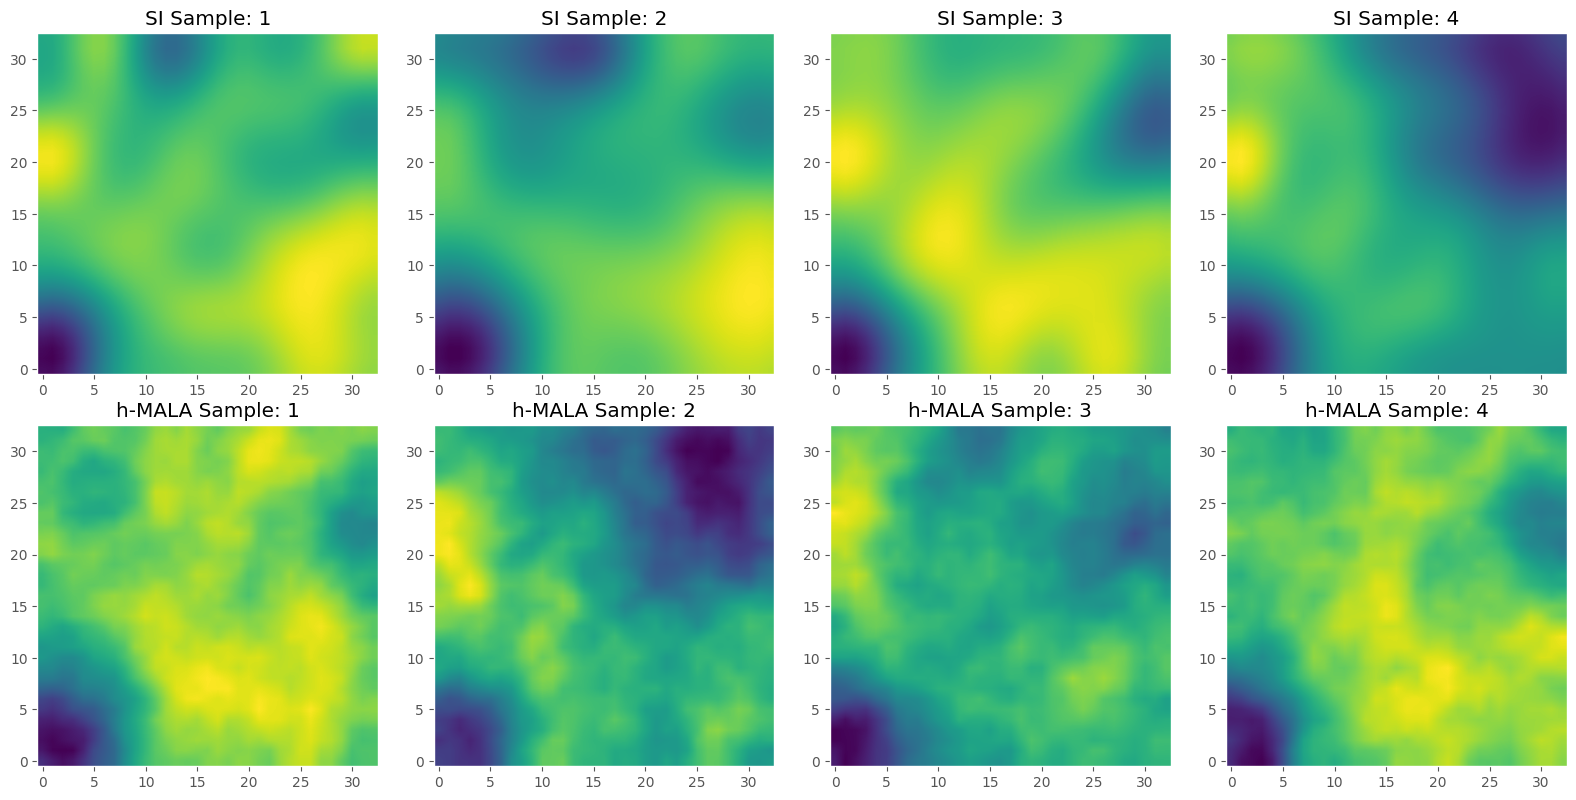

: 

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

for i in range(len(ax)):
    if i == 0:
        for j in range(len(ax[i])):
            ax[i][j].imshow(
                u_samples[np.random.choice(u_samples.shape[0]), :, :],
                origin="lower",
                interpolation="bilinear",
            )
            ax[i][j].set_title(f"SI Sample: {j + 1}")
            ax[i][j].grid(False)
    else:
        for j in range(len(ax[i])):
            ax[i][j].imshow(
                hmala_samps[np.random.choice(hmala_samps.shape[0]), :, :],
                origin="lower",
                interpolation="bilinear",
            )
            ax[i][j].set_title(f"h-MALA Sample: {j + 1}")
            ax[i][j].grid(False)
plt.tight_layout()